# Pygimli synthetic data study

## written by Anton Ziegon

<div class="alert alert-info">
<h4>Summary of this script</h4>

In this script the simplified geologic model (which was created in Gempy) is reproduced in pygimli. The Gempy model could not be used due to an error in the Gempy-to-pygimli-function (not yet fixed). Forward calculations of geophysical methods (ERT, TraveltimeTomography) are performed on the resulting Model/Mesh. The resulting synthetic data will be inverted in the following Notebook ``RM_pygimli_inversion.ipynb``.

In [86]:
# Importing pygimli
import  pygimli                    as     pg
import  pygimli.meshtools          as     mt
from    pygimli.physics            import ert
from    pygimli.physics            import TravelTimeManager
from    pygimli.physics.traveltime import createRAData
from    pygimli.physics            import gravimetry as grav

# Importing auxiliary libraries
import  numpy                      as     np
import  pandas                     as     pd
import  matplotlib.pyplot          as     plt
from    matplotlib.patches         import PathPatch 
import  os

%matplotlib inline

# Setting options
seed_val = 420
np.random.seed(seed_val)
pd.set_option('precision', 2)

## Parameter settings

In [111]:
# Model settings
class world:
    xmin = -50
    xmax = 150
    zmax = -70
    

# Material properties
class Soil:
    rho = 120       # electrical resistivity in Ohmm
    v   = 650       # seismic velocity in m/s
    k   = 10**-10   # magnetic susceptibility
    den = 1250      # mass density in kg/m^3
    
class SS:
    rho = 1200      # electrical resistivity in Ohmm
    v   = 3000      # seismic velocity in m/s (value related to sandstone with ~28% porosity)
    k   = 2*10**-4  # magnetic susceptibility
    den = 2400      # mass density in kg/m^3
    
class CSS:
    rho = 3500      # electrical resistivity in Ohmm
    v   = 3600      # seismic velocity in m/s (value related to sandstone with ~20% porosity)
    k   = 4*10**-4  # magnetic susceptibility
    den = 2500       # mass density in kg/m^3
    
class basement:
    rho = 10**8     # electrical resistivity in Ohmm
    v   = 4500      # seismic velocity in m/s (value related to sandstone with ~10% porosity)
    k   = 8*10**-4  # magnetic susceptibility
    den = 2650      # mass density in kg/m^3
    
class Diatreme:
    rho = 10**5     # electrical resistivity in Ohmm
    v   = 2000      # seismic velocity in m/s
    k   = 0.12      # magnetic susceptibility
    den = 2100      # mass density in kg/m^3 (Density of andesite 2.11 – 2.36 g/cm^3)
    
class ERT:
    e_start   = -30     # first electrode position
    e_end     = 120     # last electrode position
    n_elecs   = 76      # number of electrodes
    noiselev  = 2.5       # in prozent
    noiseabs  = 1e-6    # in volt = 0.001mV
    save_data = True
    
class TT:
    sensor_start = -40   # first geophone position
    sensor_end   = 140   # last geophone position
    n_sensors    = 91    # number of geophones
    dshot        = 3     # Distance between shot indices
    noiselev     = 1e-2  # 0.01% noise level very low as only absolute error should contribute
    noiseabs     = 1e-3  # 1ms
    save_data    = True

class GRAV:
    sensor_start = -20   # first station position
    sensor_end   = 120   # last station position
    n_sensors    = 71    # number of stations

## Creating Mesh with pygimli based on Gempy models 
(Loading model mesh did not work - error not fixed yet)

In [88]:
# Create layered subsurface
world = mt.createWorld([world.xmin,world.zmax], [world.xmax, 0], layers=[-10,-30,-60])

# Create surface points for Diatreme
pnts = [[20,-20], [30,-5], [50,-9], [70,-5], [80,-20]]
top = mt.createPolygon(pnts, addNodes=5, interpolate="spline")
left = mt.createLine([30,-70], pnts[0])
right = mt.createLine([70,-70], pnts[-1])

# Combine Diatreme and layered subsurface
geom = world + top + left + right

# Add RegionMarkers
for y in -9, -20, -50, -65:
    geom.addRegionMarker([50, y], 5)
for marker, y in enumerate([-20, -50, -65]):
    geom.addRegionMarker([100, y], marker + 2) 
    
# Create mesh
geom_mesh = mt.createMesh(geom, area=10)
mt.exportPLC(geom_mesh, 'mesh_combinedmodel.poly')

#Append a boundary region for forward calculations
#world_with_boundary = pg.meshtools.appendTriangleBoundary(world, marker=1, xbound=10, ybound=10)

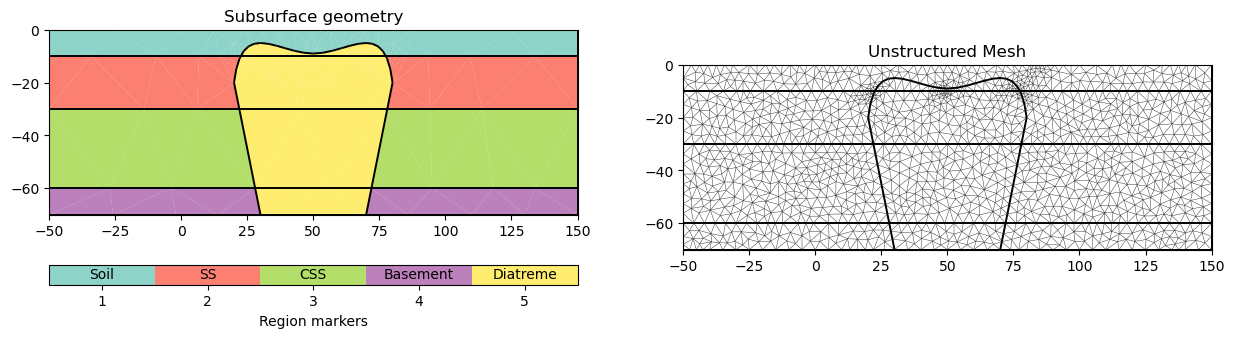

In [89]:
# Visualization of geometry
fig, (ax1,ax2) = plt.subplots(1,2,figsize=(15, 19))   
ax1.set_title('Subsurface geometry')
pg.show(geom,ax=ax1)

# Notes
plt.text(0, 0.3, 'Soil', horizontalalignment='center', ) #, bbox=dict(facecolor='magenta', alpha=0.5)
plt.text(1, 0.3, 'SS', horizontalalignment='center', )
plt.text(2, 0.3, 'CSS', horizontalalignment='center', )
plt.text(3, 0.3, 'Basement', horizontalalignment='center')
plt.text(4, 0.3, 'Diatreme', horizontalalignment='center', )

# Visualization of mesh
pg.show(geom_mesh,ax=ax2)
ax2.set_title('Unstructured Mesh')
plt.savefig('Images/Mesh.png')

### Mapping resistivity values to formations

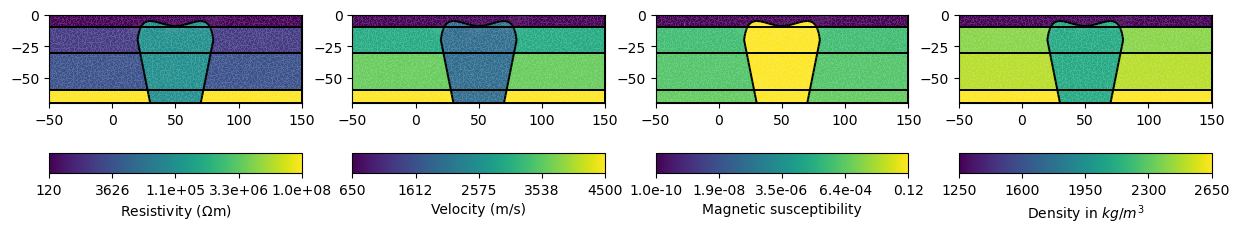

In [90]:
#Mapping typical matrial properties to units
rhomap = [[1,Soil.rho], [2,SS.rho], [3,CSS.rho], [4,basement.rho], [5,Diatreme.rho]]
vmap = [[1,Soil.v],[2,SS.v],[3,CSS.v],[4,basement.v], [5,Diatreme.v]]
kmap = [[1,Soil.k],[2,SS.k], [3,CSS.k], [4,basement.k], [5,Diatreme.k]]
denmap = [[1,Soil.den],[2,SS.den], [3,CSS.den], [4,basement.den], [5,Diatreme.den]]

#mesh = mt.createMesh(world)
fig, (ax1,ax2,ax3,ax4) = plt.subplots(1,4,figsize=(15, 19))   
pg.show(geom_mesh, ax=ax1, data = rhomap, label = pg.unit('res'), colorBar =True, logScale=True)
pg.show(geom_mesh, ax=ax2, data = vmap, label = pg.unit('vel'), colorBar =True, logScale=False)
pg.show(geom_mesh, ax=ax3, data = kmap, label = 'Magnetic susceptibility', colorBar =True, logScale=True)
pg.show(geom_mesh, ax=ax4, data = denmap, label = 'Density in $kg/m^3$', colorBar =True, logScale=False)
plt.savefig('Images/models_with_parameters.png')

### ERT forward calculation

19/12/22 - 17:35:15 - pyGIMLi - INFO - Calculate geometric factors.


relativeError set to a value > 0.5 .. assuming this is a percentage Error level dividing them by 100
Data error estimate (min:max)  0.02500030843199162 : 0.028112523874014507


19/12/22 - 17:35:16 - pyGIMLi - INFO - Calculate geometric factors.
19/12/22 - 17:35:17 - pyGIMLi - INFO - Calculate geometric factors.


relativeError set to a value > 0.5 .. assuming this is a percentage Error level dividing them by 100
Data error estimate (min:max)  0.025000100441808386 : 0.025012589279648726
relativeError set to a value > 0.5 .. assuming this is a percentage Error level dividing them by 100
Data error estimate (min:max)  0.025000100441808386 : 0.025000441393972474


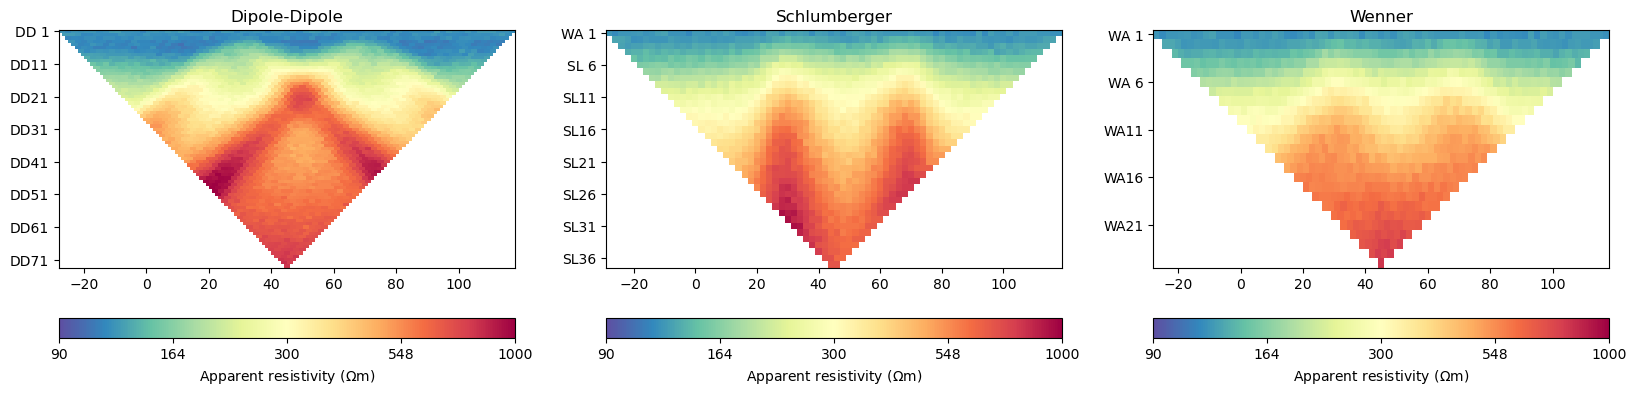

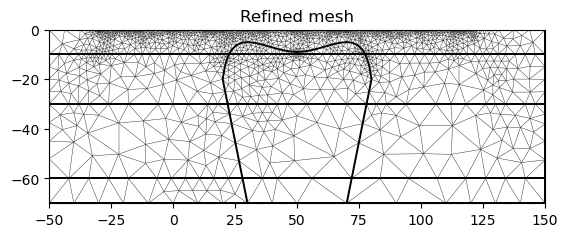

In [91]:
# Electrode configurations
ert_config = ['dd','slm','wa']

for con in ert_config:
    # Defining ERT measurement schemes
    ERT_scheme = ert.createData(elecs=np.linspace(start=ERT.e_start, stop=ERT.e_end, num=ERT.n_elecs), schemeName=con)
    
    # Create Nodes at electrode positions for improving numerical accuracy
    for s in ERT_scheme.sensors():
        geom.createNode(s + [0.0, -0.2])
    ert_mesh = mt.createMesh(geom, quality=33)
    
    # Simulating data
    ert_data = ert.simulate(ert_mesh, res=rhomap, scheme=ERT_scheme, verbose=True,
                           noiseLevel=ERT.noiselev,noiseAbs=ERT.noiseabs, seed=seed_val)

    # Save the data for further use
    if ERT.save_data == True:
        ert_data.save('SyntheticData/ert_data_'+con+'.dat')


# Inspecting data
fig, (ax1,ax2,ax3) = plt.subplots(1,3,figsize=(20, 4))     
ert.show(ert.load('SyntheticData/ert_data_dd.dat'), ax=ax1, cMin=90, cMax=1000)
ert.show(ert.load('SyntheticData/ert_data_slm.dat'), ax=ax2, cMin=90, cMax=1000)
ert.show(ert.load('SyntheticData/ert_data_wa.dat'), ax=ax3, cMin=90, cMax=1000)
ax1.set_title('Dipole-Dipole')
ax2.set_title('Schlumberger') 
ax3.set_title('Wenner') 
plt.savefig('Images/ERT_pseudosections.png')

# Inspecting refined mesh
pg.show(ert_mesh)
plt.title('Refined mesh')
plt.savefig('Images/ERT_refined_mesh.png')

### Traveltime tomography

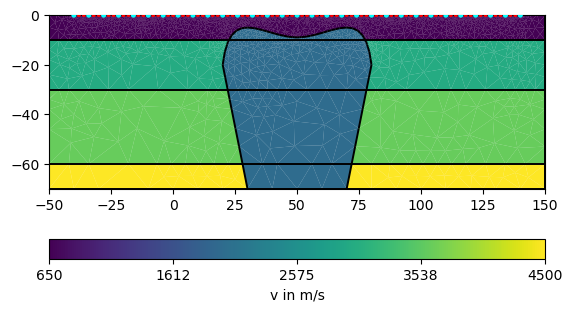

In [112]:
# Defining TT measurement schemes
TT_scheme = createRAData(np.linspace(TT.sensor_start, TT.sensor_end, TT.n_sensors),shotDistance=TT.dshot) 

# Create Nodes at electrode positions for improving numerical accuracy
for s in TT_scheme.sensors():
    geom.createNode(s + [0.0, -0.2])
tt_mesh = mt.createMesh(geom, quality=33)

# Visual Inspection
ax, _ = pg.show(tt_mesh, vmap, colorBar=True, logScale=False, label='v in m/s')
pg.viewer.mpl.drawSensors(ax, TT_scheme.sensors(), diam=1, facecolor='red', edgecolor='red')
pg.viewer.mpl.drawSensors(ax, TT_scheme.sensors()[::TT.dshot], diam=1.5, facecolor='cyan', edgecolor='cyan')
plt.savefig('Images/TT_setup.png')

# Assign velocity to nodes
vp = np.array(tt_mesh.cellMarkers())
vp[vp == vmap[0][0]] = vmap[0][1]
vp[vp == vmap[1][0]] = vmap[1][1]
vp[vp == vmap[2][0]] = vmap[2][1]
vp[vp == vmap[3][0]] = vmap[3][1]
vp[vp == vmap[4][0]] = vmap[4][1]

19/12/22 - 17:55:25 - pyGIMLi - INFO - Creating refined mesh (secnodes: 2) to solve forward task.


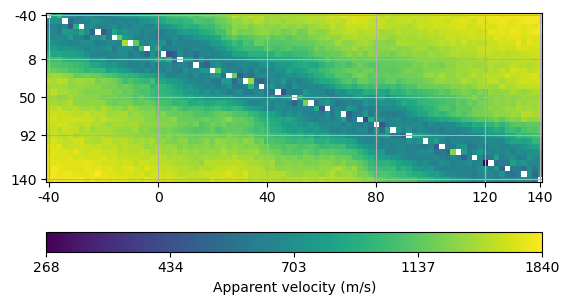

In [113]:
# Simulating data
mgr_tt = TravelTimeManager()
tt_data = mgr_tt.simulate(slowness=1.0 / vp, scheme=TT_scheme, mesh=tt_mesh,
                    noiseLevel=TT.noiselev, noiseAbs=TT.noiseabs, seed=seed_val,
                    verbose=True)
# Save for further use
if TT.save_data == True:
    tt_data.save('SyntheticData/tt_data.dat')

# Insecting data
mgr_tt.showData(tt_data,figsize=(10,10))
plt.savefig('Images/TT_syn_data.png')

### Gravimetric

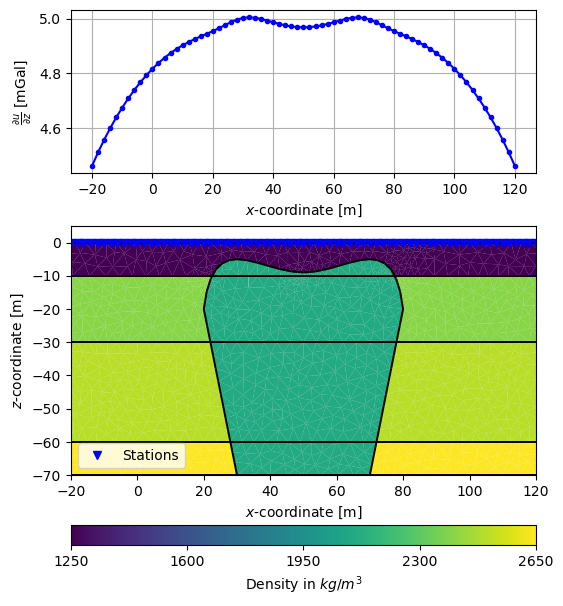

In [94]:
# Define Acquisition stations
grav_sens = np.linspace(GRAV.sensor_start,GRAV.sensor_end, GRAV.n_sensors)
grav_pnts = np.array([grav_sens, np.zeros(len(grav_sens))]).T

# Generate data
dRhoC = pg.solver.parseMapToCellArray([[1,Soil.den],[2,SS.den], [3,CSS.den], [4,basement.den], [5,Diatreme.den]], geom_mesh)
grav_data = grav.solveGravimetry(geom_mesh, dRhoC, grav_pnts)

# Visualize data
fig, (ax1,ax2) = plt.subplots(2, 1, figsize=(6, 7), gridspec_kw={'height_ratios': [1, 2]})   
ax1.plot(grav_sens, grav_data, '-b', marker='.')
pg.show(geom_mesh, ax=ax2, data = denmap, label = 'Density in $kg/m^3$', colorBar =True, logScale=False)
ax2.plot(grav_sens, grav_sens*0,'bv', label='Stations')

ax1.set_ylabel(r'$\frac{\partial u}{\partial z}$ [mGal]')
ax1.set_xlabel('$x$-coordinate [m]')
ax1.grid()

ax2.set_aspect(1)
ax2.set_xlabel('$x$-coordinate [m]')
ax2.set_ylabel('$z$-coordinate [m]')
ax2.set_ylim((-70, 5))
ax2.set_xlim((grav_sens[0],grav_sens[-1]))
ax2.legend()
plt.savefig('Images/GRVA_data.png')

<div class="alert alert-info">
<h4>Note:</h4>

The data is further used for an inversion in the next Jupyter Notebook ``RM_pygimli_inversions.ipynb``.